In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

enrolment = pd.read_parquet("../sql/data/data_cache/enrolment_clean.parquet")
demographic = pd.read_parquet("../sql/data/data_cache/demographic_clean.parquet")
biometric = pd.read_parquet("../sql/data/data_cache/biometric_clean.parquet")

In [3]:
enrolment_counts = (
    enrolment
    .groupby("state")
    .size()
    .rename("enrolment_count")
)

demographic_counts = (
    demographic
    .groupby("state")
    .size()
    .rename("demographic_update_count")
)

biometric_counts = (
    biometric
    .groupby("state")
    .size()
    .rename("biometric_update_count")
)

In [4]:
activity = (
    pd.concat(
        [enrolment_counts, demographic_counts, biometric_counts],
        axis=1
    )
    .fillna(0)
    .astype(int)
)

activity["total_updates"] = (activity["demographic_update_count"] + activity["biometric_update_count"])


In [5]:
activity["update_to_enrolment_ratio"] = (activity["total_updates"] / activity["enrolment_count"].replace(0, pd.NA))

activity = activity.sort_values("update_to_enrolment_ratio", ascending=False)

In [6]:
activity

,enrolment_count,demographic_update_count,biometric_update_count,total_updates,update_to_enrolment_ratio
state,,,,,
Andaman and Nicobar Islands,392,1724,1847,3571,9.109694
Goa,1527,5921,5428,11349,7.432220
Dadra and Nagar Haveli and Daman and Diu,416,1627,1325,2952,7.096154
Lakshadweep,159,520,550,1070,6.729560
Andhra Pradesh,65663,207740,172065,379805,5.784155
Himachal Pradesh,10346,28037,30385,58422,5.646820
Arunachal Pradesh,1601,4726,4244,8970,5.602748
Sikkim,1010,3219,2400,5619,5.563366
Puducherry,1859,4886,4918,9804,5.273803


In [7]:
output_path = "../outputs/tables/activity_update_to_enrolment_ratio.csv"
activity.to_csv(output_path, index=False)

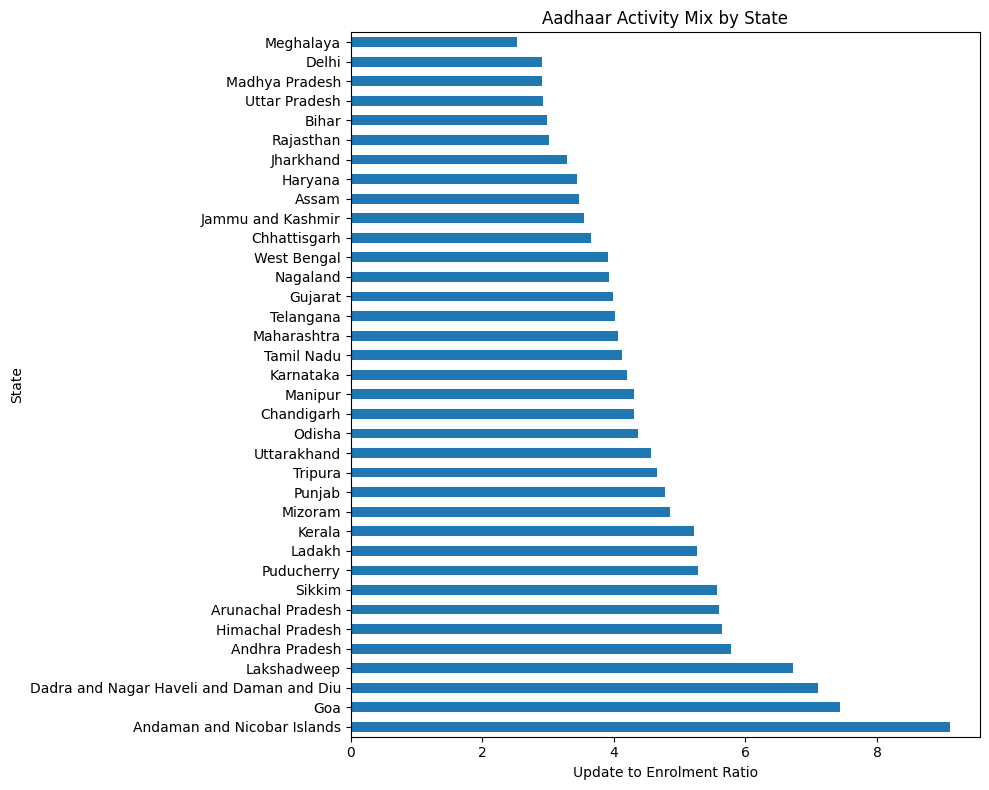

In [8]:
plt.figure(figsize=(10, 8))
activity["update_to_enrolment_ratio"].plot(kind="barh")
plt.xlabel("Update to Enrolment Ratio")
plt.ylabel("State")
plt.title("Aadhaar Activity Mix by State")
plt.tight_layout()

plt.savefig(
    "../outputs/figures/update_to_enrolment_ratio_by_state.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

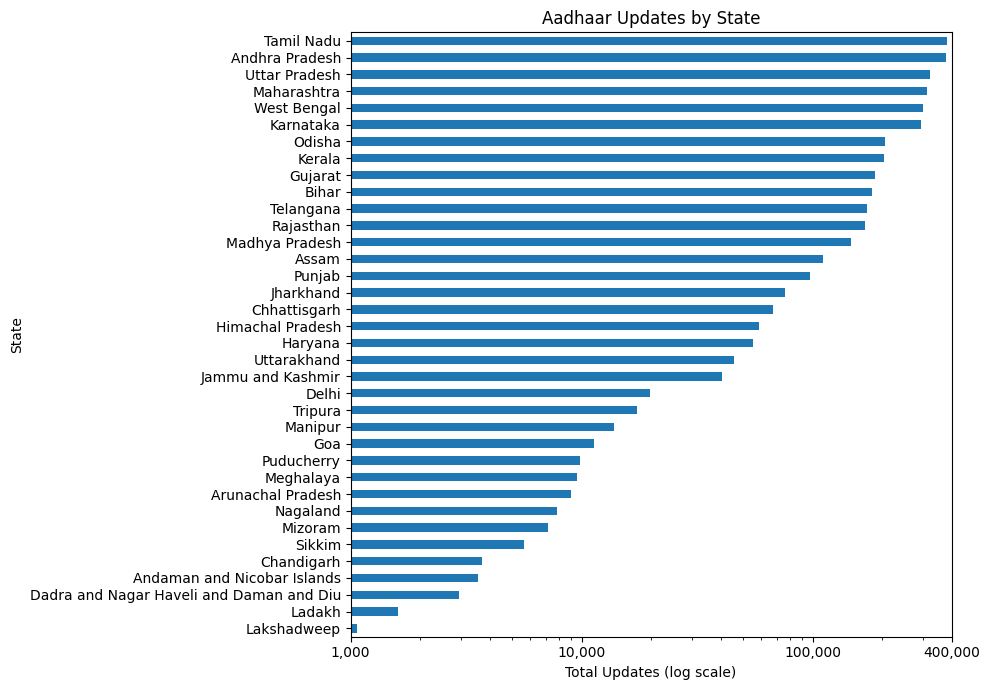

In [9]:
plt.figure(figsize=(10, 7))

ax = activity.sort_values("total_updates")["total_updates"].plot(kind="barh")

ax.set_xscale("log")
ax.set_xlim(1_000, 400_000)

# Minimal, high-signal ticks
ticks = [1_000, 10_000, 100_000, 400_000]
ax.set_xticks(ticks)

ax.get_xaxis().set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}")
)

plt.xlabel("Total Updates (log scale)")
plt.ylabel("State")
plt.title("Aadhaar Updates by State")

plt.tight_layout()

plt.savefig(
    "../outputs/figures/total_updates_by_state.png",
    dpi=300,
    bbox_inches="tight"
)


plt.show()


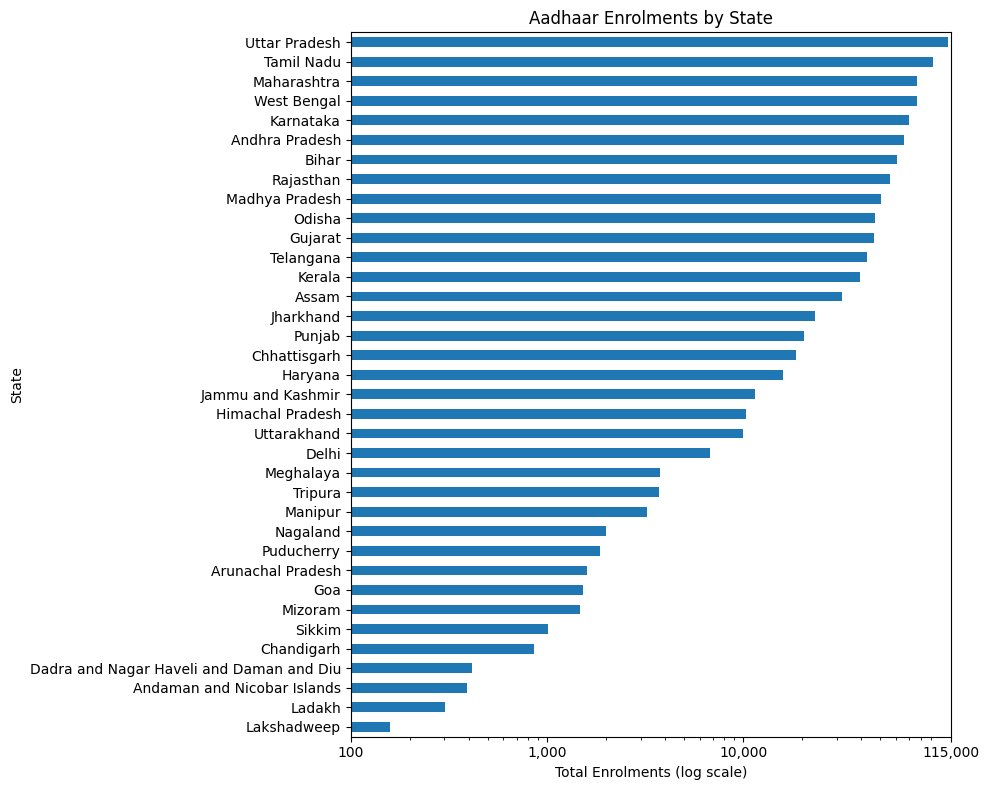

In [10]:
plt.figure(figsize=(10, 8))

ax = enrolment_counts.sort_values().plot(kind="barh")

ax.set_xscale("log")

min_val = enrolment_counts[enrolment_counts > 0].min()
max_val = enrolment_counts.max()

ax.set_xlim(min_val, max_val)

ticks = [100, 1_000, 10_000, 115_000]
ax.set_xticks(ticks)

ax.get_xaxis().set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}")
)

plt.xlabel("Total Enrolments (log scale)")
plt.ylabel("State")
plt.title("Aadhaar Enrolments by State")

plt.tight_layout()

plt.savefig(
    "../outputs/figures/total_enrolments_by_state.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

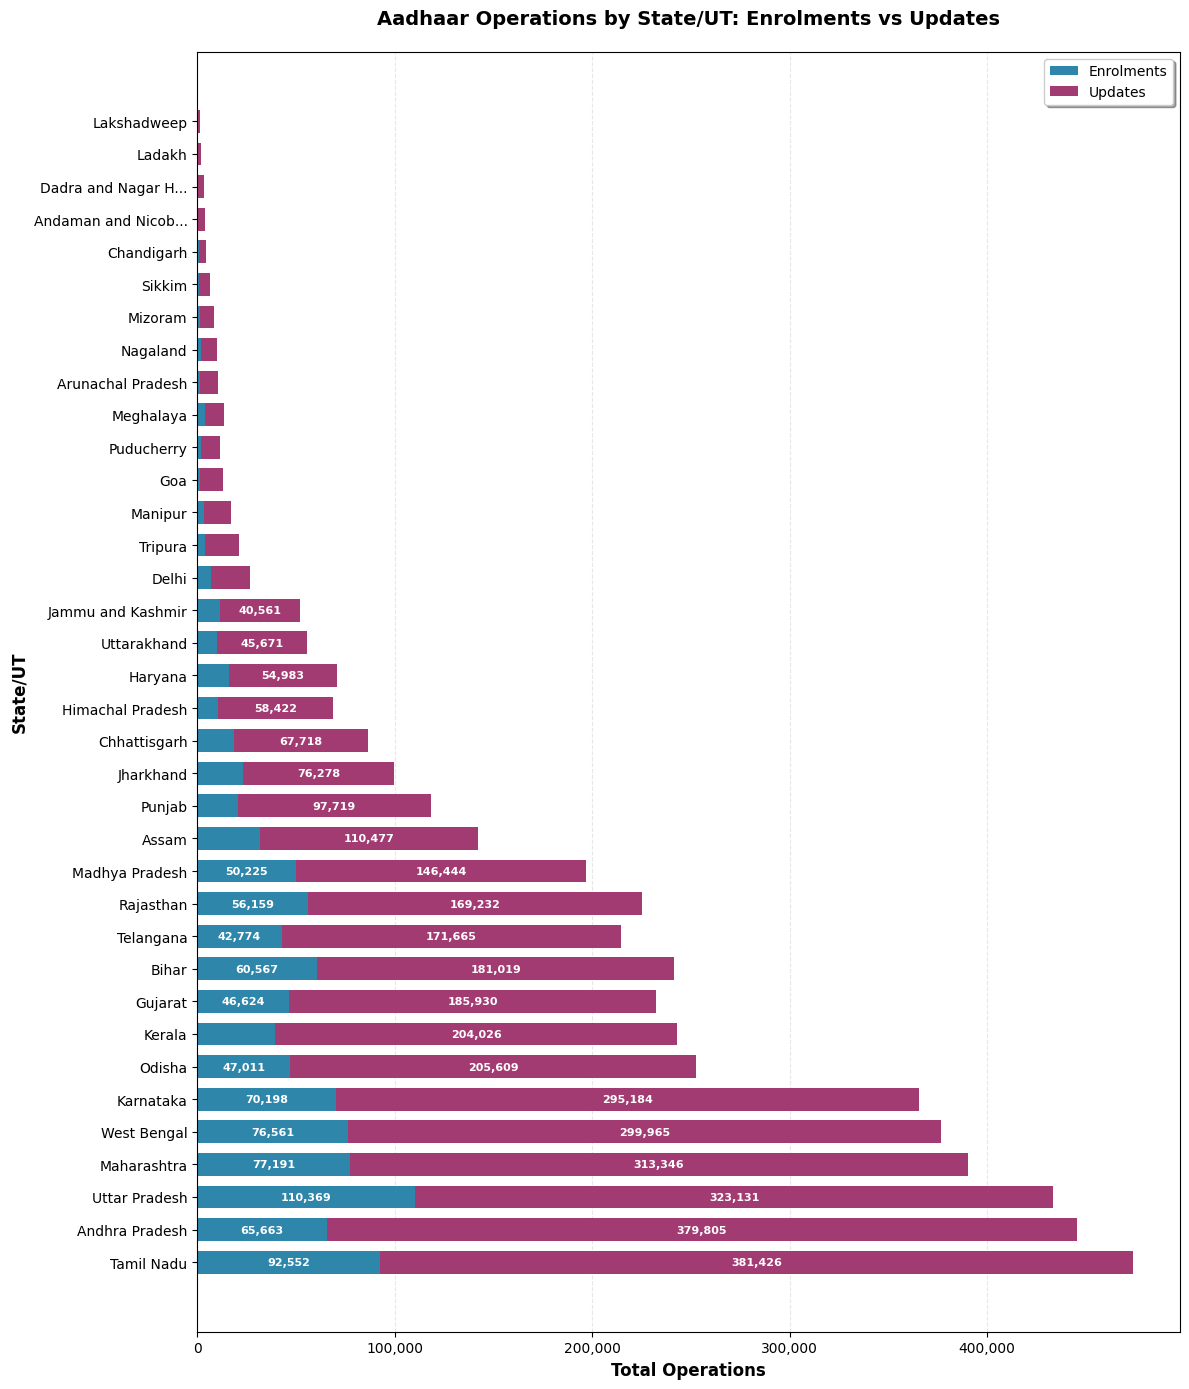

In [ ]:
activity_sorted = activity.sort_values("total_updates", ascending=False)

fig, ax = plt.subplots(figsize=(12, 14))

# Create stacked horizontal bars
bars1 = ax.barh(activity_sorted.index, activity_sorted["enrolment_count"], 
                color='#2E86AB', label='Enrolments', height=0.7)
bars2 = ax.barh(activity_sorted.index, activity_sorted["total_updates"],
                left=activity_sorted["enrolment_count"], 
                color='#A23B72', label='Updates', height=0.7)

# Add value labels on bars (only if bars are wide enough)
for i, (state, row) in enumerate(activity_sorted.iterrows()):
    total = row["enrolment_count"] + row["total_updates"]
    
    # Calculate bar widths in axis coordinates
    enrol_width = row["enrolment_count"]
    update_width = row["total_updates"]
    
    # Only show label if bar is wide enough (absolute threshold)
    max_val = activity_sorted["enrolment_count"].max() + activity_sorted["total_updates"].max()
    
    if enrol_width > max_val * 0.08:  # Show only if >8% of max total
        ax.text(enrol_width/2, i, f'{int(enrol_width):,}', 
                va='center', ha='center', color='white', fontsize=8, fontweight='bold')
    
    if update_width > max_val * 0.08:
        ax.text(enrol_width + update_width/2, i, f'{int(update_width):,}', 
                va='center', ha='center', color='white', fontsize=8, fontweight='bold')

ax.set_xlabel('Total Operations', fontsize=12, fontweight='bold')
ax.set_ylabel('State/UT', fontsize=12, fontweight='bold')
ax.set_title('Aadhaar Operations by State/UT: Enrolments vs Updates', fontsize=14, fontweight='bold', pad=20)

# Format x-axis with thousand separators
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add legend
ax.legend(frameon=True, shadow=True, fontsize=10)

# Add grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)


MAX_LEN = 20

def truncate_label(s, max_len=MAX_LEN):
    return s if len(s) <= max_len else s[:max_len - 3] + "..."

ax.set_yticks(range(len(activity_sorted.index)))
ax.set_yticklabels([truncate_label(state) for state in activity_sorted.index])

plt.tight_layout()

plt.savefig(
    "../outputs/figures/enrolments_vs_updates_by_state.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()